# Product Recommendation System for Amazon online store 

In this notebook we utilise the Amazon beauty products rating dataset found on kaggle to create a recommender system that suggest beauty products to customers.
The dataset contains over 2 Million customer ratings of Beauty related products sold on their website.
It contains
1. the unique UserId (Customer Identification),
2. the ProductId (Amazon's unique product identification code for each product),
3. Ratings (ranging from 1-5 based on customer satisfaction) and
4. the Timestamp of the rating (in UNIX time)

**The recommendation system is designed in three parts**.
1. **Popularity recommender engine**: This is  a recommender designed for new customers unto the platform where we have no purchasing history. On this engine once  new customer lands of a beauty CLP it will recommend top 10 bestselling products. The engine uses both the most popularly rated items along with their ratings to generate the top 10 products within the category. The concept behind is using best sellers tags we usually see on ecomm platforms.
2. **Model-based collaborative filtering recommender system**: This engine is more for returning customers. It uses the SVD model to predict how much a user would like a product they haven't interacted with yet, based on shared preferences between similar users or items.
For example if User A and User B both liked Product X, and User A also liked Product Y, the model might recommend Product Y to User B.
3. **Self Attention Transformer model:**: This engine uses deep learning techniques to get better product suggestion  based on customer behavior. The core idea is to use self-attention mechanisms to capture relationships between products that a user has rated and suggest products that are similar in terms of user preferences.

# MODEL

#### Import Libraries

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#### Read the data set 

In [8]:
data = pd.read_csv(r"C:\Users\Owner\Desktop\ML Recommender System Project\ratings_Beauty.csv")
data.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [9]:
# Check summary statistics
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,2023070.0,4.149036e+00,1.311505e+00,1.0,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
Timestamp,2023070.0,1.360389e+09,4.611860e+07,908755200.0,1.350259e+09,1.372810e+09,1.391472e+09,1.406074e+09


In [10]:
# check for data informartion to data type forms 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [11]:
# convert the timestamp to a proper datetime as the datatype is an int64 now 
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,2013-05-28
1,A3JM6GV9MNOF9X,0558925278,3.0,2012-12-14
2,A1Z513UWSAAO0F,0558925278,5.0,2014-07-07
3,A1WMRR494NWEWV,0733001998,4.0,2013-10-24
4,A3IAAVS479H7M7,0737104473,1.0,2010-05-19


# Exploratory Data Analysis 

In [13]:
#check for missing values
data.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

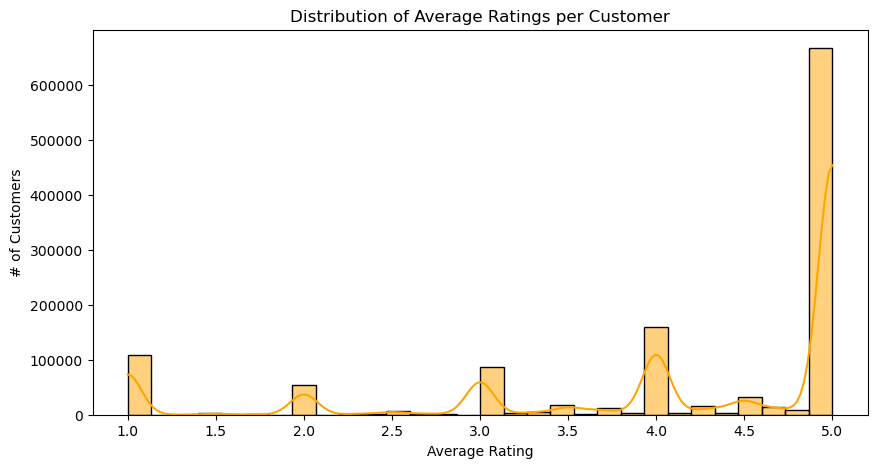

In [14]:
# Plot: Average rating per customer
avg_rating_per_customer = data.groupby('UserId')['Rating'].mean()
plt.figure(figsize=(10, 5))
sns.histplot(avg_rating_per_customer, bins=30, kde=True, color='orange')
plt.title('Distribution of Average Ratings per Customer')
plt.xlabel('Average Rating')
plt.ylabel("# of Customers")
plt.show()

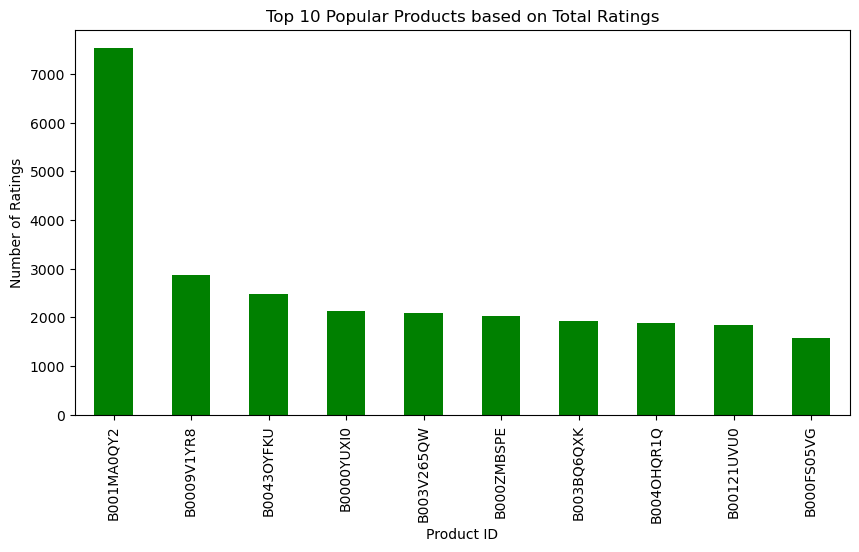

In [15]:
# Plot Popular products based on total ratings
popular_products_total = data['ProductId'].value_counts().head(10)
plt.figure(figsize=(10, 5))
popular_products_total.plot(kind='bar', title='Top 10 Popular Products based on Total Ratings', xlabel='Product ID', ylabel='Number of Ratings', color='green')
plt.show()

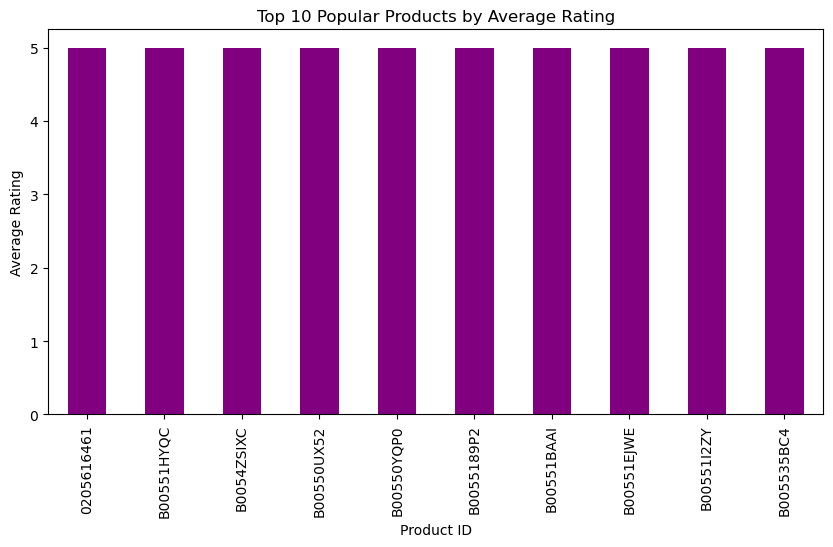

In [16]:
# Plot Popular products based on average ratings
popular_products_avg = data.groupby('ProductId')['Rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
popular_products_avg.plot(kind='bar', title='Top 10 Popular Products by Average Rating', xlabel='Product ID', ylabel='Average Rating', color='purple')
plt.show()

### Recommender Engine 1 : Popularity Based Recommendation Engine 

For this recommender engine, we use a weighted score for each product to rank them. One common method is using a weighted rating formula.

##### Weighted Rating (WR):

**WR** = *(v / (v + m)) ⋅ R + (m / (v + m)) ⋅ C*
Where:  
- **R**: Average rating of the product.  
- **v**: Number of ratings for the product.  
- **m**: Minimum number of ratings required to be considered (threshold).  
- **C**: Mean rating across all products.  
This formula ensures that products with a high number of ratings and good average ratings rank higher than those with low ratings or very few reviews.

From this we get the top 10 products which have higher ratings and have a high rating counts

In [19]:
def calculate_weighted_score(data, m_percentile=0.70):
    # Minimum ratings required to be considered
    m = data['ProductId'].value_counts().quantile(m_percentile)
    # Mean rating across all products
    C = data['Rating'].mean()

    # Calculate metrics for each product
    product_stats = data.groupby('ProductId').agg(
        total_ratings=('Rating', 'count'),
        average_rating=('Rating', 'mean')
    )

    # Filter products with enough ratings
    qualified_products = product_stats[product_stats['total_ratings'] >= m].copy()  # Explicitly create a copy

    # Weighted rating formula
    qualified_products['weighted_score'] = (
        (qualified_products['total_ratings'] / (qualified_products['total_ratings'] + m)) * qualified_products['average_rating'] +
        (m / (qualified_products['total_ratings'] + m)) * C
    )

    # Sort by weighted score
    top_products = qualified_products.sort_values('weighted_score', ascending=False).head(10)
    return top_products

# Apply the function
top_weighted_products = calculate_weighted_score(data)
print("Top 10 recommendations for new customers on the beauty CLP are:")
print(top_weighted_products)

Top 10 recommendations for new customers on the beauty CLP are:
            total_ratings  average_rating  weighted_score
ProductId                                                
B004CNRDBU             58        5.000000        4.945099
B00K7ER6LU             85        4.976471        4.939283
B001F0RBRE             41        5.000000        4.924359
B00FPROWWU             79        4.962025        4.922845
B00466VJ04             38        5.000000        4.918956
B004AI5756             38        5.000000        4.918956
B002YFN49I             98        4.948980        4.917609
B005V247N8             37        5.000000        4.916979
B00KH6F6TM             58        4.965517        4.912841
B009OWSHQE             88        4.943182        4.908654


### Recommender Engine 2 : Popularity Based Recommendation Engine 

This engine is specifically designed for returning customers with prior shopping and rating history. Here the system suggests products based on their past interactions and the preferences of similar users.
A collaborative filtering system called Singular Value Decomposition (SVD) is used.
The way the model trains is using some sort of  matrix factorization to generalize preferences across customers  and products. 
Then capturing latent (hidden) relationships, such as a customers inclination toward a specific product category. then produce specific product suggestion. 

In [22]:
# import the suprise library
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

In [23]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(data[['UserId', 'ProductId', 'Rating']], reader)

In [24]:
# Train test and split dataset 
trainset, testset = train_test_split(data_surprise, test_size=0.2)
# Train SVD model (Singular Value Decomposition)
model = SVD()
model.fit(trainset)

In [25]:
# Predict on test set
predictions = model.test(testset)

In [26]:
# Evaluate model performance
rmse = accuracy.rmse(predictions)
print(f"Collaborative Filtering Model RMSE: {rmse}")

RMSE: 1.2489
Collaborative Filtering Model RMSE: 1.2488630083184908


In [27]:
# Make a top 10 product recommendations for a returning customer
def recommend_for_user(model, user_id, data, n=10):
    user_products = data[data['UserId'] == user_id]['ProductId'].unique()
    all_products = data['ProductId'].unique()
    products_to_predict = [p for p in all_products if p not in user_products]
    predictions = [(product, model.predict(user_id, product).est) for product in products_to_predict]
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

sample_user = data['UserId'].iloc[0]
recommendations = recommend_for_user(model, sample_user, data)
print(f"Top recommendations for user {sample_user}:", recommendations)

Top recommendations for user A39HTATAQ9V7YF: [('B0006B0VNY', 5), ('B000KDWVYU', 5), ('B0011XVS42', 5), ('B001LNOEKC', 5), ('B002CMLH6A', 5), ('B003MWZI32', 5), ('B00466VJ04', 5), ('B005R4LSX2', 5), ('B007TP0V8U', 5), ('B009OWSHQE', 5)]


### Recommender Engine 3: Self-Attention Transformer 

Here we Encoded customer IDs representing individual users and  encoded product IDs representing items the user interacts with.
These inputs are embedded into dense vectors via the embedding layers, creating numerical representations for users and products.
We then create an embedding layer. These embeddings capture learned latent features, such as a user’s preferences and a product's attributes.
We then add self attention layers. This helps the model focus on the relationships between items that a user has interacted with (or rated).
The self-attention layer outputs a vector summarizing the dependencies between the user and the products they’ve interacted with are generated.
The self-attention output is passed through a feed-forward network (FFN) to learn more complex relationships. 
The final output layer is a The final output is a single value, representing the predicted rating of a product for a given user.

In [46]:
#import libaries
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [48]:
#preprocess the data Encoding UserId and ProductId using LabelEncoder
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()
data['UserId_encoded'] = user_encoder.fit_transform(data['UserId'])
data['ProductId_encoded'] = product_encoder.fit_transform(data['ProductId'])

In [50]:
#Create the user-item interaction matrix
num_users = data['UserId_encoded'].nunique()
num_products = data['ProductId_encoded'].nunique()

In [52]:
# Define the Transformer Model using Functional API
# Input layers for user and product
user_input = layers.Input(shape=(1,), name="User_Input")
product_input = layers.Input(shape=(1,), name="Product_Input")
# Embedding layers for users and products
user_embedding = layers.Embedding(input_dim=num_users, output_dim=50, name="User_Embedding")(user_input)
product_embedding = layers.Embedding(input_dim=num_products, output_dim=50, name="Product_Embedding")(product_input)
# Apply Self-Attention Mechanism
attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=50, name="Self_Attention")(
    query=user_embedding, key=product_embedding, value=product_embedding
)
# Feed-forward layer
ffn_output = layers.Dense(128, activation="relu", name="FFN_1")(attention_output)
ffn_output = layers.Dense(50, name="FFN_2")(ffn_output)
# Output layer to predict ratings
predicted_rating = layers.Dense(1, name="Output_Layer")(ffn_output)

In [54]:
# create the Self attention Recommder Model
model = tf.keras.Model(inputs=[user_input, product_input], outputs=predicted_rating, name="Transformer_Recommender")
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [68]:
# Prepare training data
X_train = [data['UserId_encoded'].values.reshape(-1, 1),data['ProductId_encoded'].values.reshape(-1, 1)]
y_train = data['Rating'].values
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=5, batch_size=2048, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/5
791/791 ━━━━━━━━━━━━━━━━━━━━ 274s 346ms/step - loss: 1.7273 - val_loss: 1.7060
Epoch 2/5
791/791 ━━━━━━━━━━━━━━━━━━━━ 1375s 2s/step - loss: 1.7216 - val_loss: 1.7061
Epoch 3/5
791/791 ━━━━━━━━━━━━━━━━━━━━ 275s 347ms/step - loss: 1.7237 - val_loss: 1.7069
Epoch 4/5
791/791 ━━━━━━━━━━━━━━━━━━━━ 927s 1s/step - loss: 1.7220 - val_loss: 1.7072


In [90]:
# get evlaution metrics to see model performance
def precision_at_k(predicted, ground_truth, k):
    """Calculate Precision@K for a single user."""
    predicted_top_k = set(predicted[:k])
    relevant_items = set(ground_truth)
    return len(predicted_top_k & relevant_items) / k

# Example usage
predicted_items = ["0737104473", "1234567890", "0987654321"]  # Predicted top-K product IDs
ground_truth_items = ["0737104473", "4567891234"]  # Actual product IDs the user interacted with

precision = precision_at_k(predicted_items, ground_truth_items, k=5)
print(f"Precision@K: {precision}")


Precision@K: 0.2


In [88]:
# Example user ID
user_id = "A3IAAVS479H7M7"  # example user id as a string

# Encode the user ID
encoded_user_id = user_encoder.transform([user_id])[0]

# Get all available product IDs from the original dataset
all_product_ids = data['ProductId'].unique()

# Encode all product IDs
encoded_product_ids = product_encoder.transform(all_product_ids)

# Prepare inputs for prediction
user_input = np.array([encoded_user_id] * len(encoded_product_ids))  # repeat the user ID for all products
product_input = np.array(encoded_product_ids)

# Predict ratings for all products for this user
predicted_ratings = model.predict([user_input, product_input])

# Combine product IDs with their predicted ratings
product_ratings = list(zip(all_product_ids, predicted_ratings.flatten()))

# Sort by predicted ratings in descending order
top_10_products = sorted(product_ratings, key=lambda x: x[1], reverse=True)[:10]

# Print the top 5 product suggestions
print(f"Top 10 product suggestions for User {user_id}:")
for product_id, rating in top_10_products:
    print(f"Product ID: {product_id}, Predicted Rating: {rating}")


7790/7790 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Top 10 product suggestions for User A3IAAVS479H7M7:
Product ID: B000093I60, Predicted Rating: 4.258391380310059
Product ID: B000C1VW18, Predicted Rating: 4.2363457679748535
Product ID: B001ET6YTC, Predicted Rating: 4.22622537612915
Product ID: B001FOFI0W, Predicted Rating: 4.221830368041992
Product ID: B001C5S8Z6, Predicted Rating: 4.21655797958374
Product ID: B006T8JG0M, Predicted Rating: 4.215673923492432
Product ID: B001JB8Y0M, Predicted Rating: 4.215639591217041
Product ID: B003RR4A2M, Predicted Rating: 4.214334487915039
Product ID: B0033TF0ZK, Predicted Rating: 4.214288711547852
Product ID: B001VHLH9Y, Predicted Rating: 4.212117671966553
